### Markov Chain to predict the stock market, based on the post from Pranab Gosh "Customer Conersion Prediction with Markov Chain Classifier" (https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/) 
### -->  binary classification with two transition matrices (first ordered matrix), positive and negative

### 1) First-Order Transition Matrix

In [2]:
!pwd

/Users/mikiya/wormhole/Data/DataSci/ML/markov_chain


In [4]:
!ls pic

first-order-matrix.png


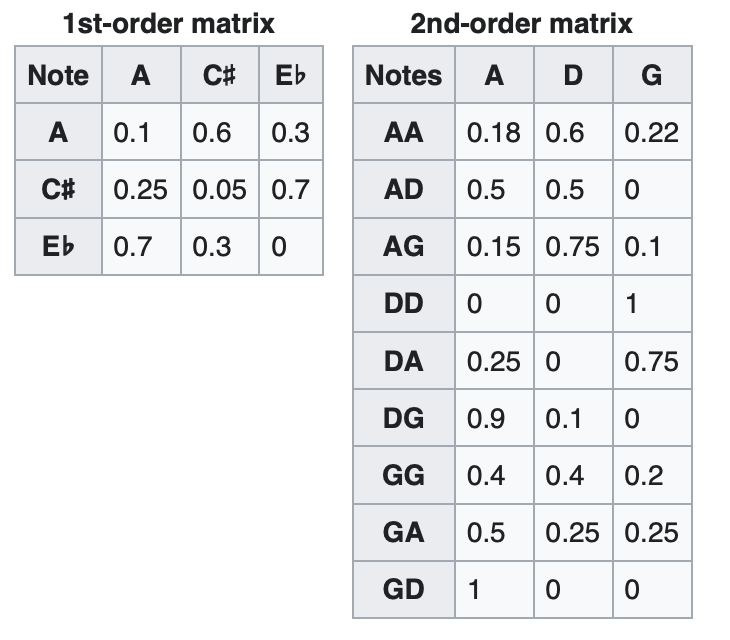

In [5]:
# insert image using python package
from IPython.display import Image
Image(filename="./pic/first-order-matrix.png", width=400)

### 2) Gataloging Patterns Using Market Data
#### &#x23f5; 10 years of S&P 500 index data represents only one sequence of many events leading to the last quoted price. Breaking data into may samples of sequences leading to different price patterns for model to learn richer and diverse patterns, I use the moving average to understand this

### 3) example
#### &#x23f5; 2012-10-18 to 2012-11-21 
1417.26 -> 1428.39 -> 1394.53 -> 1377.51 -> Next Day Volume Up
#### &#x23f5; 2016-08-12 to 2016-08-22
2184.05 -> 2190.15 -> 2178.15 -> 2182.22 -> 2187.02 -> Next Day Volume Up 
#### &#x23f5; 2014-04-04 to 2014-04-10
1865.09 -> 1854.04 -> Next Day Volume Down

### 4) if any similar price up and down has found compared to historical data in the current dataset, I consider that's a pattern
### 5) Binning Values into n(3) Buckets
In Pranab Ghosh's approach is to simplify each even within a sequence into a single feature. He split the value into 3 groups - Low, Medium, High. The precent difference between one day's price and the previous day's. Once we have collected all of them, binning them into three groups of equal frequency(number of appearance?) using InfoTheo package.
### 6) example
#### &#x23f5; closes, opens, highs, lows, we'll end up with a feature containing four letters: "MLHL" for example
#### &#x23f5; String all the feature events for the sequence and end up with something like this along with the observed outcome: "HMLL" -> "MHHL" -> "LLLH" -> "HMMM" -> Volume Up
### 7) Creating Two Markov Chains, One for Days with Volume Jumps, and another for Volume Drops

-----

-----

# Import Libraries

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import io, base64, os, json, re
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime
from random import randint

## 1) Loading Data

In [57]:
# data extraction from date: 2012-12-01 to 2022-12-01, 10 years in total
start_date = "2012-12-01"
end_date = "2022-12-01"

# choosing Tesla for prediction, ticker symbol: TSLA
symbol = "TSLA"
tsla_stock = DataReader(name=symbol, data_source="yahoo", start=start_date, end=end_date)
tsla_stock = tsla_stock[["Open", "High", "Low", "Adj Close", "Volume"]]

In [61]:
tsla_stock.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2012-12-03,2.259333,2.333333,2.233333,2.308000,31285500.0
2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500.0
2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500.0
2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000.0
2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000.0


## 2) calculating return and range 
1) **Return**: is the change in price of an asset over time, a positive return represents a profit while a negative return marks a loss. Here I used the close price from previous date minus today's price <br>
2) **Range**: the difference between the highest and lowest prices traded for a defined period (day, month or year). Here I used high minus low within a day

In [62]:
# add return and range 
df = tsla_stock.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1 # because latter - previous will cause the last row has no one to divide with, so exclude that row
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500.0,-0.020797,0.037258
2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500.0,-0.005605,0.018165
2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000.0,0.005636,0.038806
2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000.0,0.007965,0.018907
2012-12-10,2.295333,2.320000,2.278667,2.304667,13947000.0,0.011706,0.018139


## 3) Turn Date from index to attributes

In [63]:
# show all the columns, since Date is not listed as a column, so it should have been recongized as index
df.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Returns', 'Range'], dtype='object')

In [64]:
df.index

DatetimeIndex(['2012-12-04', '2012-12-05', '2012-12-06', '2012-12-07',
               '2012-12-10', '2012-12-11', '2012-12-12', '2012-12-13',
               '2012-12-14', '2012-12-17',
               ...
               '2022-11-17', '2022-11-18', '2022-11-21', '2022-11-22',
               '2022-11-23', '2022-11-25', '2022-11-28', '2022-11-29',
               '2022-11-30', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [65]:
# reset index 
df.reset_index(inplace=True)

In [66]:
# convert Date columns into datetime type 
df["Date"]  = pd.to_datetime(df["Date"])

In [67]:
df.head()

,Date,Open,High,Low,Adj Close,Volume,Returns,Range
0,2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500.0,-0.020797,0.037258
1,2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500.0,-0.005605,0.018165
2,2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000.0,0.005636,0.038806
3,2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000.0,0.007965,0.018907
4,2012-12-10,2.295333,2.320000,2.278667,2.304667,13947000.0,0.011706,0.018139


## 4) Randomize
**step 1. select a certain number of rows, calculating the percentage change between previous day and current day, form a new sub dataset with these new attributes** <br>
**step 2. using pandas built-in method -> pct_change(): (current_date - previous_date) / previous_date** <br>
**step 3. repeat this process for 100,000 times, and therefore will collect 100,000 sub dataset** <br>
**step 4. concatenate those 100,000 dataset as new huge dataset** <br> 

In [121]:
# randomize sequential rows from stock price (that will possibly cause certain pattern), collecting them into a list first
random_set = []

# for loop randomize
for i in range(0, 100000):
    
    nums_of_rows = randint(10, 40) # randomly select a certain number from 10 to 40 as the quantities of a sub dataset
    row_to_begin = randint(0, len(df) - nums_of_rows) # randomly select a row to begin with as forming the sub dataset
    sub_dataset = df.iloc[row_to_begin : row_to_begin + nums_of_rows]
    
    # select the last date in each subset as an indicator for predicting 
    Close_Date = max(sub_dataset["Date"])
    
    # forming the new dataset with new attributes 
    Close_Change = sub_dataset["Adj Close"].pct_change()
    High_Change = sub_dataset["High"].pct_change() 
    Low_Change = sub_dataset["Low"].pct_change() 
    Volume_Change = sub_dataset["Volume"].pct_change() 
    Return_Change = sub_dataset["Returns"].pct_change()
    
    Daily_Change = (sub_dataset["Adj Close"] - sub_dataset["Open"]) / sub_dataset["Open"]
    Volume_Next_Day_Tendency = (sub_dataset["Volume"].shift(-1) - sub_dataset["Volume"]) # use volume as prediction 
    Return_Next_Day_Tendency = (sub_dataset["Returns"].shift(-1) - sub_dataset["Returns"]) # use return as prediction
    
    random_set.append(pd.DataFrame({'Sequence_ID': [nums_of_rows] * len(sub_dataset),
                                    'Close_Date': [Close_Date]*len(sub_dataset),
                                    'Close_Change': Close_Change,
                                    'High_Change': High_Change,
                                    'Low_Change': Low_Change,
                                    'Volume_Change': Volume_Change, 
                                    'Daily_Change': Daily_Change,
                                    'Next_Day_Volume_Outcome': Volume_Next_Day_Tendency,
                                    'Next_Day_Return_Outcome': Return_Next_Day_Tendency}))

In [122]:
# there are 100,000 randomly distributed dataset
len(random_set)

100000

In [123]:
# concatenate random_set 
tsla_df = pd.concat(random_set)
print(f'the shape of new dataset before dropping NaN rows: {tsla_df.shape}')

# drop rows with NaN value 
tsla_df = tsla_df.dropna(how='any')
print(f'the shape of new dataset after dropping NaN rows: {tsla_df.shape}')

# display the some data
tsla_df.tail(20)

the shape of new dataset before dropping NaN rows: (2495747, 9)
the shape of new dataset after dropping NaN rows: (2295747, 9)


,Sequence_ID,Close_Date,Close_Change,High_Change,Low_Change,Volume_Change,Daily_Change,Next_Day_Volume_Outcome,Next_Day_Return_Outcome
27,24,2013-02-12,0.010635,-0.019389,0.023046,-0.408201,0.005441,10486500.0,0.008607
28,24,2013-02-12,0.019242,0.026064,0.007001,0.755702,0.023860,-3690000.0,-0.013343
29,24,2013-02-12,0.005900,-0.000584,0.019650,-0.151459,0.007385,877500.0,0.002312
30,24,2013-02-12,0.008211,0.018113,0.005633,0.042447,0.006440,31776000.0,-0.004139
31,24,2013-02-12,0.004072,-0.002008,-0.002948,1.474490,-0.006333,-24523500.0,0.015337
32,24,2013-02-12,0.019409,0.022139,0.013010,-0.459875,0.018229,-5338500.0,0.003609
33,24,2013-02-12,0.023018,0.019409,0.020432,-0.185345,0.027984,6091500.0,0.004482
34,24,2013-02-12,0.027500,0.040839,0.025171,0.259605,0.027500,-10239000.0,-0.027771
35,24,2013-02-12,-0.000271,-0.004772,0.026786,-0.346427,-0.000541,10473000.0,0.028664
36,24,2013-02-12,0.028394,0.031167,0.001631,0.542165,0.031742,-8391000.0,-0.030497


In [124]:
# head 
tsla_df.head()

,Sequence_ID,Close_Date,Close_Change,High_Change,Low_Change,Volume_Change,Daily_Change,Next_Day_Volume_Outcome,Next_Day_Return_Outcome
1041,27,2017-03-01,0.022859,0.015585,0.016904,-0.207156,0.018440,2656500.0,-0.023409
1042,27,2017-03-01,-0.000550,0.014364,0.008612,0.035666,-0.011037,-29857500.0,-0.007152
1043,27,2017-03-01,-0.007702,-0.010524,-0.004170,-0.387061,-0.007000,213000.0,0.009445
1044,27,2017-03-01,0.001742,-0.010714,-0.008893,0.004505,0.006245,9522000.0,-0.010914
1045,27,2017-03-01,-0.009172,0.009051,-0.005714,0.200486,-0.007524,4725000.0,0.014359


## 5) Categoricalize the numeric data
**step 1. binning data in each attributes with equal frequency, assign them with labels as the following "L", "M", "H", where "L" means low, "M" means middle, "H" means high** <br>
**step 2. label attributes in each rows as an event pattern, as X; excluding Next_Day_Volume_Outcome and Next_Day_Return_Outcome as Y for prediction** <br>
**step 3. group event pattern for the same date**

In [125]:
# make a copy of the numeric dataset 
tsla_new_df = tsla_df.copy()

In [127]:
# create sequences
# simplify the data by binning values into three groups
 
# Close_Change
tsla_new_df['Close_Gap_LMH'] = pd.qcut(tsla_new_df['Close_Change'], 3, labels=["L", "M", "H"])

# High_Change (not used)
tsla_new_df['High_Gap_LMH'] = pd.qcut(tsla_new_df['High_Change'], 3, labels=["L", "M", "H"])

# Low_Change (not used)
tsla_new_df['Low_Gap_LMH'] = pd.qcut(tsla_new_df['Low_Change'], 3, labels=["L", "M", "H"])

# Volume_Change
tsla_new_df['Volume_Gap_LMH'] = pd.qcut(tsla_new_df['Volume_Change'], 3, labels=["L", "M", "H"])
 
# Daily_Change
tsla_new_df['Daily_Change_LMH'] = pd.qcut(tsla_new_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
tsla_new_df = tsla_new_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Next_Day_Volume_Outcome",
                          "Next_Day_Return_Outcome"]]

tsla_new_df['Event_Pattern'] = tsla_new_df['Close_Gap_LMH'].astype(str) + tsla_new_df['Volume_Gap_LMH'].astype(str) + tsla_new_df['Daily_Change_LMH'].astype(str)
 

/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_71649/2364666317.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_new_df['Event_Pattern'] = tsla_new_df['Close_Gap_LMH'].astype(str) + tsla_new_df['Volume_Gap_LMH'].astype(str) + tsla_new_df['Daily_Change_LMH'].astype(str)


In [128]:
tsla_new_df.tail(10)

,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Next_Day_Volume_Outcome,Next_Day_Return_Outcome,Event_Pattern
37,24,2013-02-12,M,L,M,-6877500.0,-0.009227,MLM
38,24,2013-02-12,L,L,M,-1000500.0,0.011065,LLM
39,24,2013-02-12,M,M,L,2988000.0,0.021327,MML
40,24,2013-02-12,H,H,M,411000.0,-0.035682,HHM
41,24,2013-02-12,L,M,L,2733000.0,0.024955,LML
42,24,2013-02-12,M,H,M,8745000.0,0.016941,MHM
43,24,2013-02-12,H,H,H,-10449000.0,-0.019361,HHH
44,24,2013-02-12,M,L,M,-852000.0,-0.013993,MLM
45,24,2013-02-12,M,M,M,31897500.0,-0.014818,MMM
46,24,2013-02-12,L,H,H,-15075000.0,0.007102,LHH


In [129]:
# describe the volume outcome 
tsla_new_df['Next_Day_Volume_Outcome'].describe()

count    2.295747e+06
mean     3.618782e+04
std      5.780919e+07
min     -4.922427e+08
25%     -2.161650e+07
50%     -2.235000e+06
75%      1.858260e+07
max      4.975683e+08
Name: Next_Day_Volume_Outcome, dtype: float64

In [130]:
# describe the return outcome 
tsla_new_df["Next_Day_Return_Outcome"].describe()

count    2.295747e+06
mean     1.275108e-06
std      5.072057e-02
min     -3.090148e-01
25%     -2.732725e-02
50%     -6.419813e-04
75%      2.583036e-02
max      3.442209e-01
Name: Next_Day_Return_Outcome, dtype: float64

## 6) Grouping Data
**event pattern**: grouping pattern for the same day {MMM, MHM, LML, ..., etc} <br>
**outcome mean**: (aggregated all outcome) / quantities

In [193]:
# groupby function will apply self defined function to all columns
pattern_df = tsla_new_df.groupby(['Sequence_ID', 
                                     'Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(tsla_new_df.shape)
pattern_df.head() 

(2295747, 8)


,Sequence_ID,Close_Date,Event_Pattern
0,10,2012-12-18,"{MMM, MMM, MHM, HHH, MHM, LML, MLM, HLH, MMM, ..."
1,10,2012-12-19,"{MMM, MHM, HHH, MHM, LML, MLM, HLH, MHH}"
2,10,2012-12-24,"{MHM, LML, MLM, HLH, MHH, MLM, MLM, LHM, MHM, ..."
3,10,2012-12-27,"{MLM, HLH, MHH, MLM, MLM, LHM, MLH, LHL}"
4,10,2012-12-31,"{MHH, MLM, MLM, LHM, MLH, LHL, MMM, LLM, MHH, ..."


In [194]:
# calculating mean outcome using volume
### Calculate Mean of One Column Grouped by Multiple Columns
volume_outcome = tsla_new_df.groupby(['Sequence_ID', 'Close_Date'])['Next_Day_Volume_Outcome'].mean()
volume_outcome = volume_outcome.to_frame().reset_index()
return_outcome = tsla_new_df.groupby(['Sequence_ID', 'Close_Date'])['Next_Day_Return_Outcome'].mean()
return_outcome = return_outcome.to_frame().reset_index()

# describe dataset
# outcomes were shrinked to 56084 rows
print(volume_outcome.shape)
print(volume_outcome.describe())
print()
print(return_outcome.shape)
print(return_outcome.describe())

(56084, 3)
        Sequence_ID  Next_Day_Volume_Outcome
count  56084.000000             5.608400e+04
mean      24.952981             3.520313e+04
std        8.943765             5.111179e+06
min       10.000000            -8.483456e+07
25%       17.000000            -1.491877e+06
50%       25.000000            -1.503947e+03
75%       33.000000             1.474520e+06
max       40.000000             7.741462e+07

(56084, 3)
        Sequence_ID  Next_Day_Return_Outcome
count  56084.000000             56084.000000
mean      24.952981                -0.000005
std        8.943765                 0.002974
min       10.000000                -0.033760
25%       17.000000                -0.001217
50%       25.000000                -0.000002
75%       33.000000                 0.001187
max       40.000000                 0.039950


In [195]:
# merge pattern dataset and volume outcome dataset 
volume_set = pd.merge(pattern_df, volume_outcome, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(volume_set.shape)

(56084, 4)


In [196]:
# merge pattern dataset and return outcome dataset 
return_set = pd.merge(pattern_df, return_outcome, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(return_set.shape)

(56084, 4)


In [197]:
# eliminate the bracket from volume Event_pattern 
volume_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in volume_set['Event_Pattern'].values]
volume_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Next_Day_Volume_Outcome
0,10,2012-12-18,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH,MMM,MMM,MHM,HH...",1675312.5
1,10,2012-12-19,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",1189500.0
2,10,2012-12-24,"MHM,LML,MLM,HLH,MHH,MLM,MLM,LHM,MHM,LML,MLM,HL...",-3165000.0
3,10,2012-12-27,"MLM,HLH,MHH,MLM,MLM,LHM,MLH,LHL",-866062.5
4,10,2012-12-31,"MHH,MLM,MLM,LHM,MLH,LHL,MMM,LLM,MHH,MLM,MLM,LH...",-1798125.0


In [198]:
# eliminate the bracket from return Event_pattern
return_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in return_set['Event_Pattern'].values]
return_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Next_Day_Return_Outcome
0,10,2012-12-18,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH,MMM,MMM,MHM,HH...",-0.000014
1,10,2012-12-19,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",-0.000923
2,10,2012-12-24,"MHM,LML,MLM,HLH,MHH,MLM,MLM,LHM,MHM,LML,MLM,HL...",0.001100
3,10,2012-12-27,"MLM,HLH,MHH,MLM,MLM,LHM,MLH,LHL",-0.000372
4,10,2012-12-31,"MHH,MLM,MLM,LHM,MLH,LHL,MMM,LLM,MHH,MLM,MLM,LH...",0.001755


In [199]:
# use last x days of data for validation, test for volume first. Use last 90 days for validation
volume_validation = volume_set[volume_set['Close_Date'] >= datetime.datetime.now() 
                                           - datetime.timedelta(days=90)] # current - 90 days: last 90 days

# first date to 90 days before current date for test set 
volume_test = volume_set[volume_set['Close_Date'] < datetime.datetime.now() 
                                           - datetime.timedelta(days=90)]  
print(volume_test.shape)
print(volume_validation.shape)

(54802, 4)
(1282, 4)


In [200]:
# check final dataset's attribute
list(volume_set)

['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Next_Day_Volume_Outcome']

In [201]:
# drop date field
volume_test = volume_test[['Sequence_ID', 'Event_Pattern','Next_Day_Volume_Outcome']]
volume_validation = volume_validation[['Sequence_ID', 'Event_Pattern','Next_Day_Volume_Outcome']]

## 7) Keep Big change for building outcome variable

In [202]:
# check volume outcome properties
volume_test['Next_Day_Volume_Outcome'].describe()

count    5.480200e+04
mean     2.488138e+04
std      5.164760e+06
min     -8.483456e+07
25%     -1.534598e+06
50%     -2.055335e+04
75%      1.485569e+06
max      7.741462e+07
Name: Next_Day_Volume_Outcome, dtype: float64

In [203]:
print(len(volume_test['Next_Day_Volume_Outcome']))
len(volume_test[abs(volume_test['Next_Day_Volume_Outcome']) > 1000000])

54802


34427

In [209]:
# keep only keep big/interesting change in volume for test set
print('all moves:', len(volume_test))
volume_test_set = volume_test[abs(volume_test['Next_Day_Volume_Outcome']) > 1000000]
volume_test_set['Next_Day_Volume_Outcome'] = np.where((volume_test_set['Next_Day_Volume_Outcome'] > 0), 1, 0)

# for validation set
volume_validation_set = volume_validation.copy()
volume_validation_set['Next_Day_Volume_Outcome'] = np.where((volume_validation_set['Next_Day_Volume_Outcome'] > 0), 1, 0)
print('big moves only:', len(volume_test_set)) 

all moves: 54802
big moves only: 34427


/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_71649/175137821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_test_set['Next_Day_Volume_Outcome'] = np.where((volume_test_set['Next_Day_Volume_Outcome'] > 0), 1, 0)


In [219]:
# create two new dataset later for forming positive and negative matrix 

volume_test_pos = volume_test_set[volume_test_set['Next_Day_Volume_Outcome']==1][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_pos.shape)
volume_test_neg = volume_test_set[volume_test_set['Next_Day_Volume_Outcome']==0][['Sequence_ID', 'Event_Pattern']]
print(volume_neg_pos.shape)

(1619, 2)
(17390, 2)


In [220]:
# find unique pattern, same as saying collecting all pattern into a set (not duplicate pattern)
flat_list = [item.split(',') for item in volume_test_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

27

In [221]:
# 
volume_test_set["Next_Day_Volume_Outcome"].head()

0    1
1    1
2    0
4    0
7    0
Name: Next_Day_Volume_Outcome, dtype: int64

## 8) Building Markov Transition Matrix (grid)

In [222]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):
    # build the markov transition grid

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # loop from unique pattern, starting with something like this: MMM, HLH

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)] # count the occurence in both positive and negative matrix of each pattern combination
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    #del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

In [223]:
grid_pos = build_transition_grid(volume_test_pos, unique_patterns) 
grid_neg = build_transition_grid(volume_test_neg, unique_patterns) 

/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_71649/3562671906.py:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_71649/3562671906.py:24: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_71649/3562671906.py:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
/var/folders/m8/t4_ccmx91k78k5w10tj3pgt40000gn/T/ipykernel_71649/3562671906.py:24: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  grid_Df['x

In [225]:
grid_pos.head()

,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.132913,0.059364,0.152733,0.122650,0.415846,0.116598,0.108392,0.304063,0.290986,0.077005,...,0.023905,0.031649,0.079993,0.089529,0.180443,0.189676,0.141480,0.146753,0.207256,0.105324
HHL,0.015143,0.000000,0.000054,0.007472,0.000000,0.022883,0.017838,0.000000,0.000169,0.000177,...,0.000309,0.000000,0.000000,0.000318,0.000475,0.032773,0.014982,0.000190,0.000339,0.000256
HHM,0.022401,0.064343,0.000922,0.047984,0.000000,0.063606,0.033782,0.085190,0.000846,0.000000,...,0.000309,0.075632,0.000327,0.075740,0.035126,0.034980,0.043932,0.019660,0.087649,0.009825
HLH,0.063615,0.221946,0.081978,0.013151,0.000000,0.028830,0.035607,0.074924,0.034194,0.000355,...,0.080886,0.146062,0.110420,0.024590,0.035736,0.117847,0.055807,0.076484,0.118589,0.084069
HLL,0.000142,0.000000,0.000000,0.009102,0.000000,0.024689,0.008411,0.000000,0.000000,0.080199,...,0.000206,0.000000,0.000000,0.000254,0.000000,0.013924,0.000222,0.006405,0.000254,0.000047


In [229]:
grid_neg.head()

,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.103809,0.054958,0.159115,0.064158,0.411528,0.092704,0.059409,0.125238,0.146926,0.050010,...,0.021881,0.111820,0.027065,0.080437,0.150049,0.158713,0.154401,0.069874,0.180477,0.122019
HHL,0.006576,0.000000,0.000262,0.010860,0.000000,0.009904,0.001229,0.000293,0.000000,0.000834,...,0.000000,0.000277,0.000000,0.000142,0.000000,0.017896,0.026572,0.000133,0.000000,0.000000
HHM,0.028342,0.026105,0.001441,0.018647,0.000000,0.046621,0.026467,0.035049,0.000100,0.001459,...,0.000088,0.011376,0.000155,0.021421,0.016240,0.041154,0.038474,0.012276,0.018740,0.024215
HLH,0.046530,0.089993,0.067182,0.004573,0.002821,0.108334,0.060013,0.178765,0.073613,0.002917,...,0.076760,0.119312,0.201361,0.032274,0.095876,0.140154,0.073879,0.156735,0.162087,0.080654
HLL,0.000054,0.000687,0.000131,0.005882,0.000000,0.022906,0.016149,0.000147,0.000000,0.040633,...,0.000000,0.000000,0.000155,0.000000,0.000000,0.019945,0.000014,0.006636,0.000000,0.000000


In [231]:
volume_validation_set.head()

,Sequence_ID,Event_Pattern,Next_Day_Volume_Outcome
1812,10,"LML,HMM,HMH,HMH,HMH,HMH,LHM,HMH",1
1813,10,"HMM,HMH,HMH,HMH,HMH,LHM,HMH,MMM",1
1814,10,"HMH,HMH,HMH,HMH,LHM,HMH,MMM,MHH,HMH,HMH,HMH,HM...",1
1815,10,"HMH,HMH,HMH,LHM,HMH,MMM,MHH,HLH",1
1816,10,"HMH,LHM,HMH,MMM,MHH,HLH,MMM,LML",1


In [233]:
# compressed_set_validation[compressed_set_validation['Sequence_ID' == seq_id]]
# testing the correctness for prediction using validation set

def safe_log(x,y):
   try:
      lg = np.log(x/y)
   except:
      lg = 0
   return lg

# predict on out of sample data
actual = []
predicted = []
for seq_id in volume_validation_set['Sequence_ID'].values:
    patterns = volume_validation_set[volume_validation_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    pos = []
    neg = []
    log_odds = []
    
    for id in range(0, len(patterns)-1):
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            if (numerator == 0 and denominator == 0):
                log_value =0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0
        
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
      
    print('outcome:', volume_validation_set[volume_validation_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(volume_validation_set[volume_validation_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    predicted.append(sum(log_odds))

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.988760835196615
-1.0264407727617817
outcome: 1
0.9887608

outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883
outcome: 0
1.0661270812679604
0.21510430996977883


outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781067058579
0.4761545667831775
outcome: 0
1.0108781

outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9962686960507946
-0.23591287569073227
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-0.38304712237893795
outcome: 0
0.9882383102482857
-

array([[326, 428],
       [ 84, 444]])

In [234]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 60.06 %


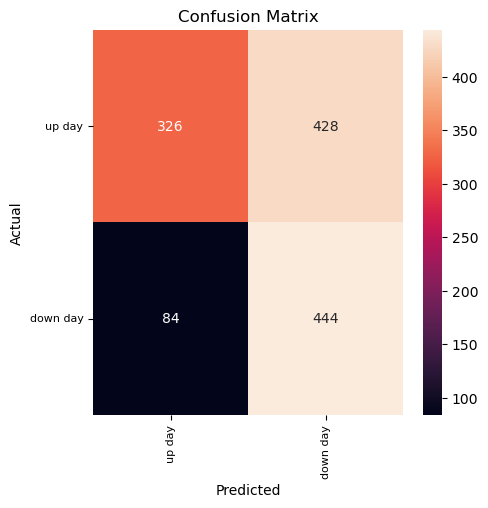

In [235]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

### Data

In [236]:
# data extraction 
start_date = '2017-01-1'
end_date = '2022-06-01'
symbol = "SPY"
data = DataReader(name=symbol, data_source="yahoo", start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Adj Close", "Volume"]]

In [237]:
# add return and range 
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1 # because latter - previous value in row level 
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,205.000427,78744400.0,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,204.837570,78379000.0,-0.000794,0.004879
2017-01-06,226.529999,227.750000,225.899994,205.570374,71559900.0,0.003577,0.008189
2017-01-09,226.910004,227.070007,226.419998,204.891846,46939700.0,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,204.891846,63771900.0,0.000000,0.006371


In [238]:
# structure data 
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2017-01-04,0.005949,0.005053
2017-01-05,-0.000794,0.004879
2017-01-06,0.003577,0.008189
2017-01-09,-0.003301,0.002871
2017-01-10,0.000000,0.006371


### HMM Learning

In [240]:
from pyhhmm.gaussian import GaussianHMM
# Train Model 
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x2986c7190>, 9610.221523377466)

In [241]:
# check results 
hidden_states = model.predict([X_train.values])[0]
hidden_states[:40]
len(hidden_states)

1362

In [242]:
# regime state means for each feature 
model.means

array([[-0.0012525 ,  0.01022438],
       [ 0.0239186 ,  0.03291859],
       [-0.00812345,  0.02684074],
       [ 0.0031774 ,  0.00714904]])

In [243]:
# 
model.covars

array([[[ 8.64338657e-05,  1.12975598e-05],
        [ 1.12975598e-05,  5.00522231e-05]],

       [[ 1.00237369e-03,  7.34549902e-04],
        [ 7.34549902e-04,  7.29351479e-04]],

       [[ 5.18139261e-04, -9.16665206e-05],
        [-9.16665206e-05,  2.18584356e-04]],

       [[ 4.00413432e-05,  2.44949309e-05],
        [ 2.44949309e-05,  2.74465725e-05]]])

In [ ]:
# helper function
# dir(model)

### Data Visualization

In [244]:
# structure the prices for plotting 
i = 0
labels_0 = []
labels_1 = [] 
labels_2 = [] 
labels_3 = []
prices = df["Adj Close"].values.astype(float)
print("Correct number of rows:", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

Correct number of rows: True


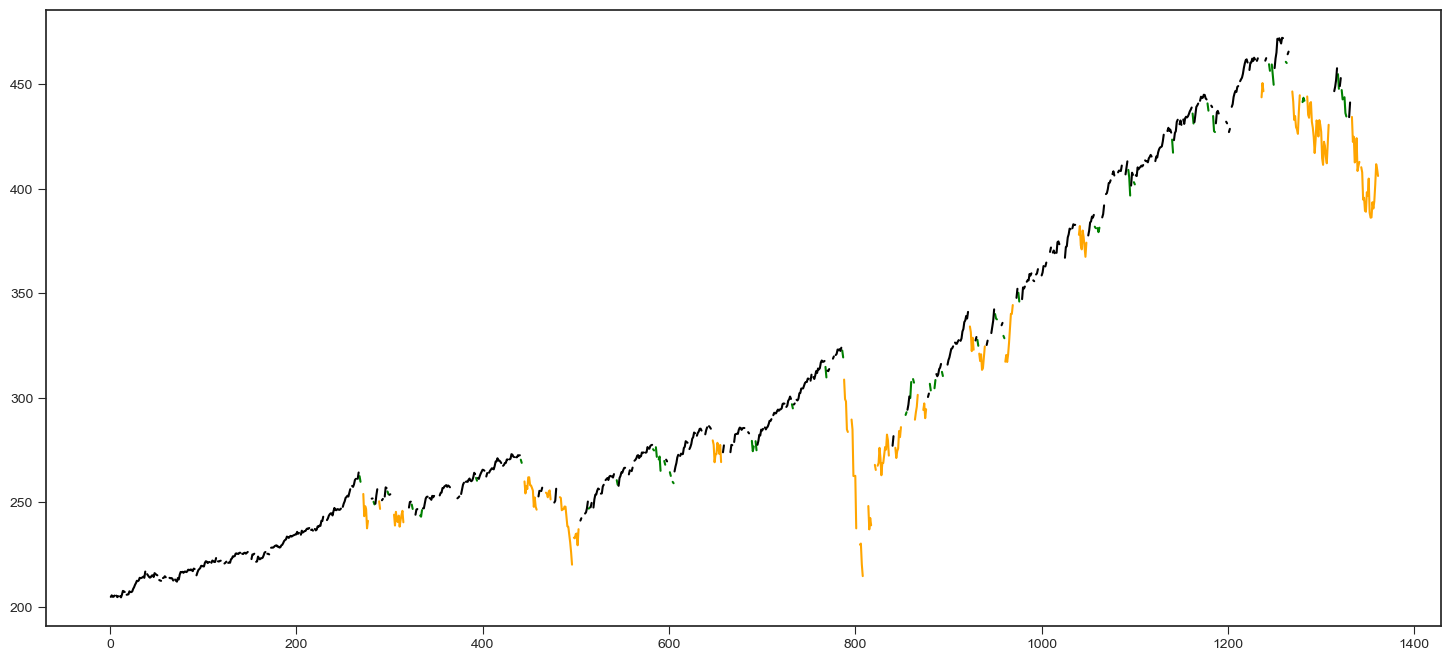

In [245]:
# plot chart 
fig = plt.figure(figsize=(18, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="red")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

In [ ]:
# moving average 
# https://www.youtube.com/watch?v=r3Ulu0jZCJI
# define a period as a day, for example a 20 days moving average, take value of 20 days and adding together / count
# this result is used as a value for the first day of that 20 days 
# when moving forward a day, drop the current first day and include a new day followed the current last day
# and do the calculation for that

In [ ]:
# binning data: make continuous data into categorical data
# https://www.youtube.com/watch?v=iv_ec0EfXcE

# equal frequency binding in python